# 分析シナリオ　回帰分析による不動産価格の予想


回帰分析では「The Boston house-price data」と呼ばれる有名なデータセットを使います。このデータは米国国税調査局が収集した情報をベースに作成されたデータセットです。ボストンの町ごとの「犯罪率」や「非小売業の割合」など、全部で14の属性(列)を持ったデータセットになっています。本サンプルコードでは、青色の13個の属性と赤色の1個の属性の関連性を学習し、予測モデルを構築します。すなわち、その町の13個の属性から、赤色の属性、つまり住宅価格を予測するモデルを構築するというものです。

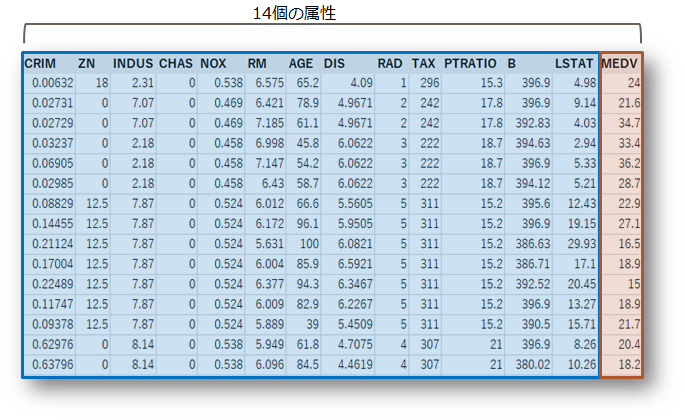!

各列の概要は以下の通りです。

- CRIM： 犯罪率
- ZN：広い家の割合(25,000平方フィートを超える住宅地の割合)
- INDUS：非小売業の割合
- CHAS：チャールズ川隣接状況(隣接の場合：1、隣接していない場合：0）
- NOX： 一酸化窒素濃度
- RM：平均部屋数
- AGE：築古の割合(1940年より前に建てられた持ち家の割合)
- DIS：主要施設への距離(ボストン雇用センターまでの加重距離)
- RAD：主要高速道路へのアクセス性指数
- TAX：固定資産税率(10,000ドル当たり)
- PTRATIO：生徒と先生の比率
- LSTAT：低所得者人口の割合
- MEDV：住宅価格(1000ドル単位の中央値)

まず初めに必要なライブラリをimportします。機械学習では集めたデータを配列に入れ込んで、データの操作や処理を行います。そのため、多次元配列用のライブラリやデータ操作のためのライブラリ(numpy、pandas)が必要になります。また、データを視覚化しチャートとして表示するためのライブラリ(seaborn、maploptlib)をインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline

次に、データのロードです。上述したボストンの不動産価格情報のデータセットはscikit-learnに含まれていますので、以下のようなコードで簡単にデータのロードができます。

In [2]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

データ操作の処理をするために、boston_datasetをpandasのデータフレームに変換し、head()でデータを確認してみます。

データ操作の処理をするために、boston_datasetをpandasのデータフレームに変換し、head()でデータを確認してみます。

In [4]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


予測対象の不動産価格情報(MEDV)の列がありませんね。これが正解ラベルになりますから、このデータフレームにMEDVの列を追加する処理を下記のように行います。このようにデータ処理を簡単に行えるようにするために、学習データをpandasのデータフレームに変換しておくということになります。

In [5]:
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


上記のように、正解ラベルである、MEDVの列が追加されていることがわかります。ここから簡単なデータの確認作業をしてみましょう。まず初めに行うべきは、データの欠落があるかどうかの確認です。下記のようにisnull()で簡単に確認できます。

In [6]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

全てゼロなので、欠損値はないということが確認できました。
ここからより詳しく、データを把握してゆきます。データの把握と一言でいってもその作業は様々です。しかし、もっとも重要なことは、そのデータの「分布」を把握するということです。ですので、このデータセットで非常に重要な特徴量であるMEDV(不動産価格)の分布を、先にimportしたseabornでチャート化してみましょう。

/home/datascience/conda/generalmachinelearningforcpusvy/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


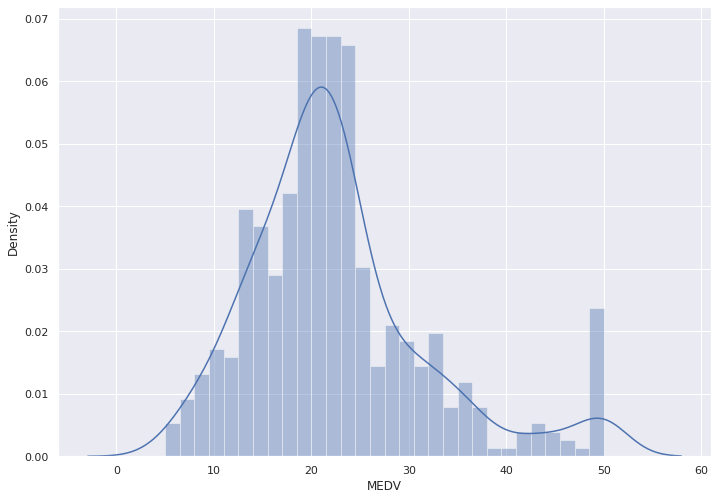

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()

まず、外れ値がほとんどないということ、そして、値が明らかに正規分布であることがわかります。正規分布とは連続値のデータが平均値あたりに集中し、最小値、最大値に近づくにつれて、減少するような分布のことを言います。このような偏りの少ないデータはそのまま機械学習にかけやすいデータと言えるでしょう。

そして、次に重要な確認が、各特徴量の相関関係になります。これも下記のように、seabornを使ってヒートマップ形式で表示することにより、一目で相関関係の強さが確認できます。

<AxesSubplot:>

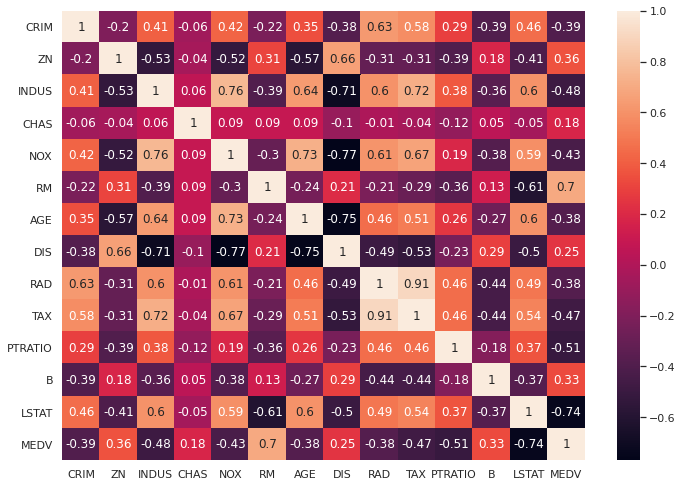

In [8]:
correlation_matrix = boston.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

縦軸と横軸に全ての特徴量がプロットされ、その相関関係の強さを色の具合によって直感的に把握することができます。相関関係は-1から1の間の値で表示され、ゼロから-1に近づくにつれて、負の相関関係が強く、ゼロから1に近づくにつれて、正の相関関係が強いということになります。相関関係はその計算式から、以下のような傾向を把握するために、正と負があります。

- ある特徴量が大きくなれば、もう一つの特徴量も大きくなる場合、相関係数は正で表される
- ある特徴量が大きくなれば、もう一つの特徴量は小さくなる場合、相関係数は負で表される

今回の回帰分析では線形回帰と呼んでいるアルゴリズムを利用します。線形回帰では、予測対象の特徴量を目的変数、その他の特徴量を説明変数と呼びます。目的変数と相関関係の強い説明変数を使って機会学習を行うと精度の高い予測モデルが作れそうだということは直感的にわかりますよね。
また、説明変数同士の相関関係が高い場合、多重共線性と呼んでいる症状が発生し、正確な精度を把握することができなくなるため、特に回帰問題では注意が必要です。
したがって、上述したヒートマップから、相関関係をちゃんと把握し、学習に使う特徴量を選別することが重要になります。(※実際の分析の現場では、ここは試行錯誤を繰り返したり、AutoMLの機能で対応したりします)

このbostonのデータセットのヒートマップを具体的に見てみると、

- 特徴量DISとAGEは0.75、RADとTAXは0.91という強い相関関係にあるため、説明変数には使えなさそう
- 目的変数であるMEDV(不動産価格)と相関の強い、LSTAT(低所得者人口の割合)と、RM(平均部屋数)は説明変数として使えそう

という状況なので、今回はシンプルにこのLSTATとRMを説明変数の候補にして学習してみたいと思います。学習の前に、念のため、説明変数の候補であるLSTAT、RMと、目的変数であるMEDVをチャートにして見てみましょう。

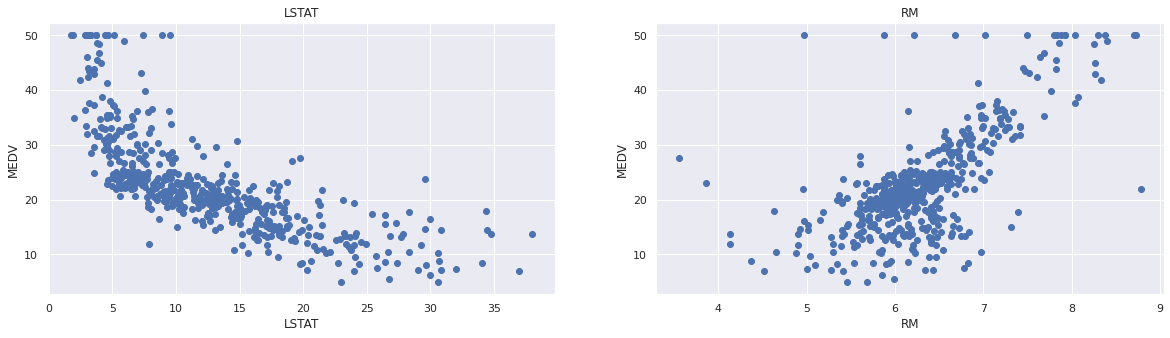

In [9]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

おぼろげに以下のような傾向があるように見えますよね。

LSTATが大きくなるにつれて、MEDVは小さくなる(つまり、低所得者の割合が増えるにつれて、その所有者の不動産価格は低い)
RMが大きくなるにつれて、MEDVは大きくなる(つまり、部屋数が増えるにつれて、不動産価格は高くなる)
という感じで、感覚的に納得感がある分布で、このデータセットは非常にわかりやすいですね。

説明変数が決まれば、次は学習のフェーズです。下記のコードで、この2つの説明変数からXという名前で説明変数のみのデータフレームを作ります。そしてYという名前で目的変数だけのデータフレームを作ります。

In [10]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']

データフレームXの内容を確認してみます。説明変数であるLSTATとRMの列で505行のデータから構成されていることがわかります。

In [11]:
print(X)

     LSTAT     RM
0     4.98  6.575
1     9.14  6.421
2     4.03  7.185
3     2.94  6.998
4     5.33  7.147
..     ...    ...
501   9.67  6.593
502   9.08  6.120
503   5.64  6.976
504   6.48  6.794
505   7.88  6.030

[506 rows x 2 columns]


データフレームYの内容を確認してみます。目的変数であるMDEVの列で、Xと同じく505行のデータから構成されていることがわかります。

In [12]:
print(Y)

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64


そして、作成したデータフレームを、次のコードで学習用データ(X_train, Y_train)と評価用データ(X_test, Y_test)に分割します。評価用が0.2とあり、これはデータ量の20%を意味します。つまり、80%のデータで学習し、作った予測モデルを20%のデータで評価するということになります。

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [14]:
print(X_train)

     LSTAT     RM
33   18.35  5.701
283   3.16  7.923
418  20.62  5.957
502   9.08  6.120
402  20.31  6.404
..     ...    ...
486  14.98  6.114
189   5.39  7.185
495  17.60  5.670
206  10.97  6.326
355   5.57  5.936

[404 rows x 2 columns]


できあがったデータを学習にかけます。学習に使うアルゴリズムは線形回帰(LinearRegression)と呼んでいるものです。LinearRegression()から予測モデルlin_modelを作成し、fit関数で学習をしています。もちろん、説明変数のデータフレームであるX_trainと目的変数のY_trainの関係性を学習するためにこの2つのデータフレームがfit関数の引数となっていることが下記コードからわかります。

In [16]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

これで学習が完了し、予測モデルが構築できましたので、実際に予測処理を行ってみたいと思います。予測するデータは学習時に利用しなかった X_test から一行抜き出して、そのデータで予測をします。

In [20]:
X_pred = X_test.iloc[0:1]
X_pred

,LSTAT,RM
226,3.13,8.04


このデータから不動産価格を予測させる処理を行います。LSTATが3.21、RMが8.04のときに不動産の価格MEDVがいくつになるのかを予測します。予測処理を行う前に、正解を確認しておきましょう。

In [23]:
Y_pred = Y_test.iloc[0:1]
Y_pred

226    37.6
Name: MEDV, dtype: float64

上記から、実際の正解はMEDV=37.6ということがわかります。この値に近しい値が予測できるかどうかが、構築した予測モデルの精度ということになります。予測処理をする場合はpredict関数を使います。

In [21]:
lin_model.predict(X_pred)

array([37.38999403])

上記の通り、37.38という値が予測できました。感覚的には、正解の37.6に比較的近しい値だと思いますが、これはたまたまかもしれません。従って、このモデルをちゃんと評価して、モデルの精度を数値化する必要がでてきます。

回帰モデルを評価する際に、最低確認しなければいけない指標は「二乗平均誤差(RMSE)」や決定係数(R2)と呼んでいるものを使います。難しそうな名前ですが、評価用データ全てに対して、予測値と、実際の正解データの乖離を計算し、どれくらいの誤差があるかというところからモデルの精度をパーセンテージで確認する手法です。

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 5.6371293350711955
R2 score is 0.6300745149331701


The model performance for testing set
--------------------------------------
RMSE is 5.137400784702911
R2 score is 0.6628996975186952


上記では、テストデータに対する評価の結果としてRMSE=5.137、R2スコアは0.662という値になりました。それほど高い値ではないので、このままでリリースするのはさすがに難しいですね。このデータセット以外のデータを追加し、説明変数を増やす必要がありそう、というような感じで、データ収集のフェーズにもどって、説明変数の設計をやり直すなど、実際の分析の現場では試行錯誤を繰り返すということになります。

以上です。